In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, lognorm, ttest_ind
from scipy.optimize import curve_fit

In [2]:
kelly = ["#ebce2b", "#702c8c", "#db6917", "#96cde6", "#ba1c30", "#c0bd7f", "#7f7e80", "#5fa641", "#d485b2", "#4277b6", "#df8461", "#463397", "#e1a11a", "#91218c", "#e8e948", "#7e1510", "#92ae31", "#6f340d", "#d32b1e", "#2b3514",]

# Reading the csv file of benchmark run

In [3]:
df = pd.read_csv('03-metrics.csv')

In [4]:
df.columns

Index(['Force Field', 'SMILES', 'Conformer Idx', 'RMSD', 'Bond RMSD',
       'Angle RMSD', 'Dihedral RMSD', 'Improper RMSD', 'TFD', 'FB OBJECTIVE',
       'Record ID', 'ddE'],
      dtype='object')

In [5]:
# a is a list
def function_hist(a, ini, final, nbins):
    bins = np.linspace(ini, final, nbins)
    counts, bins = np.histogram(np.array(a), bins)
    return counts, bins

In [6]:
ff_list = list(df['Force Field'].unique())

# RMSD/TFD/ddE distributions with rolling point average

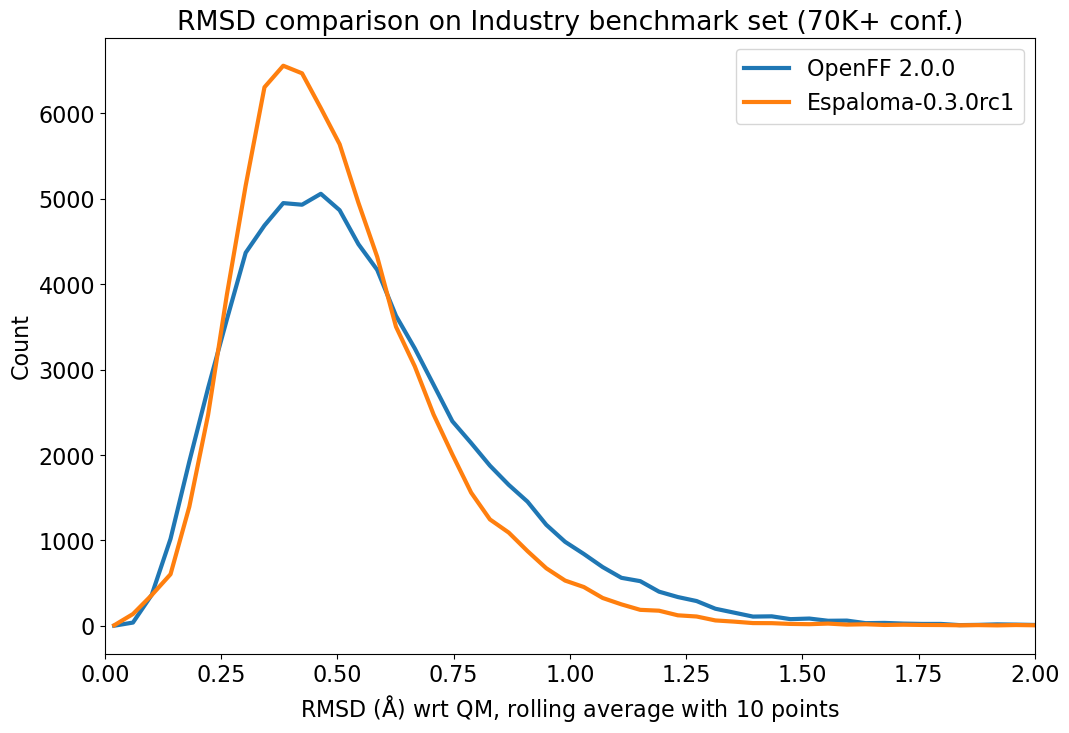

In [7]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})

average_window = 10
for forcefield in ff_list:
    t_average = df.loc[df['Force Field'] == forcefield]["RMSD"].rolling(window=average_window).mean()
    n,x = function_hist(t_average, 0, 4, 100) #plt.hist(t_average, bins = np.linspace(0,3,200), histtype=u'step', color='w')
    bin_centers = 0.5*(x[1:]+x[:-1])
    if forcefield == 'GAFF 2.11 + AM1BCC':
        plt.plot(bin_centers, n, '-.', linewidth=3, label=forcefield) ## using bin_centers rather than edges
    else:
        plt.plot(bin_centers, n, linewidth=3, label=forcefield)
plt.xlim(0, 2)        
plt.xlabel(r"RMSD ($\mathrm{\AA}$) wrt QM, rolling average with 10 points")
plt.ylabel("Count")
plt.legend()
plt.title('RMSD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'Rolling_average_of_{average_window}_RMSD.png', dpi=300)
plt.show()

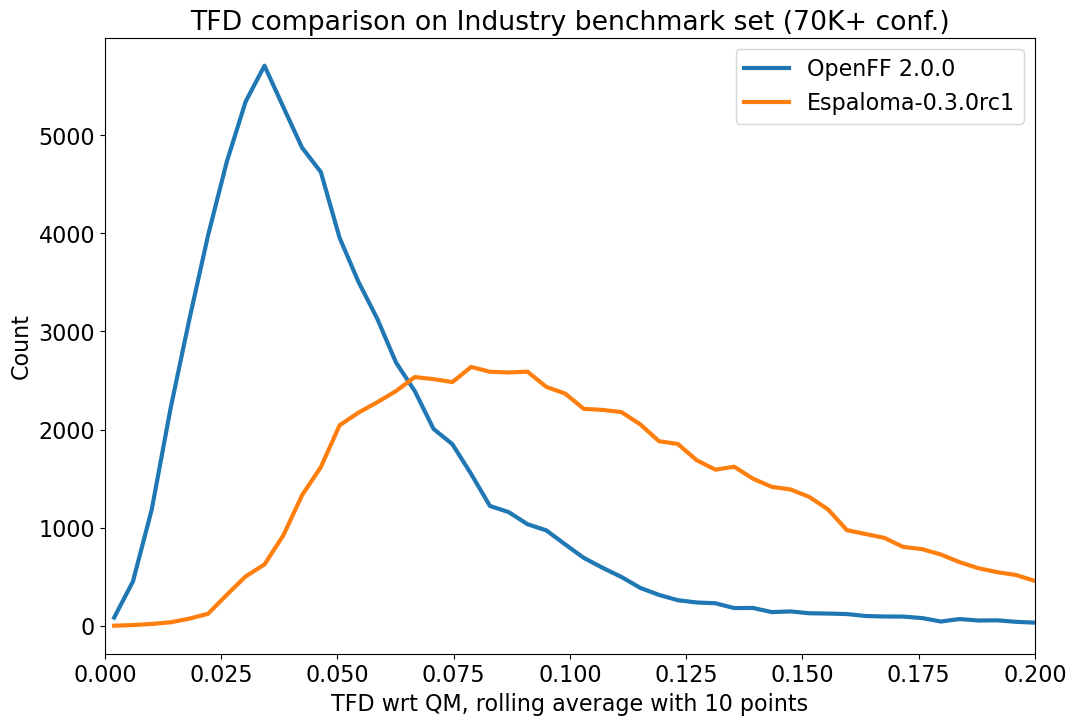

In [8]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})

average_window = 10
for forcefield in ff_list:
    t_average = df.loc[df['Force Field'] == forcefield]["TFD"].rolling(window=average_window).mean()
    n,x = function_hist(t_average, 0, 0.4, 100) #plt.hist(t_average, bins = np.linspace(0,3,200), histtype=u'step', color='w')
    bin_centers = 0.5*(x[1:]+x[:-1])
    if forcefield == 'GAFF 2.11 + AM1BCC':
        plt.plot(bin_centers, n, '-.', linewidth=3, label=forcefield) ## using bin_centers rather than edges
    else:
        plt.plot(bin_centers, n, linewidth=3, label=forcefield)

plt.xlim((0,0.2))
plt.xlabel(f"TFD wrt QM, rolling average with {average_window} points")
plt.ylabel("Count")
plt.legend()
plt.title('TFD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'Rolling_average_of_{average_window}_TFD.png', dpi=300)
plt.show()

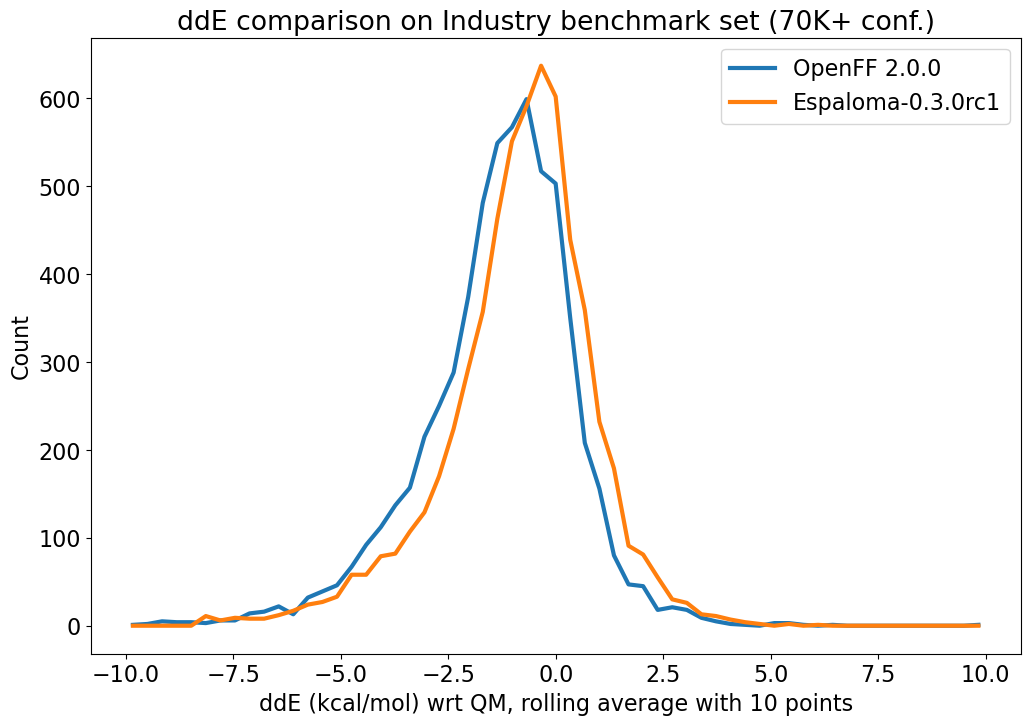

In [9]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})

average_window = 10
for forcefield in ff_list:
    t_average = df.loc[df['Force Field'] == forcefield]["ddE"].rolling(window=average_window).mean()
    n,x = function_hist(t_average, -10, 10, 60) #plt.hist(t_average, bins = np.linspace(0,3,200), histtype=u'step', color='w')
    bin_centers = 0.5*(x[1:]+x[:-1])
    if forcefield == 'GAFF 2.11 + AM1BCC':
        plt.plot(bin_centers, n, '-.', linewidth=3, label=forcefield) ## using bin_centers rather than edges
    else:
        plt.plot(bin_centers, n, linewidth=3, label=forcefield)
        
plt.xlabel(f"ddE (kcal/mol) wrt QM, rolling average with {average_window} points")
plt.ylabel("Count")
plt.legend()
plt.title('ddE comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'Rolling_average_of_{average_window}_ddE.png', dpi=300)
plt.show()



In [55]:
ttest_ind(np.abs(df.loc[df['Force Field'] == 'Sage 2.0.0']["ddE"]), np.abs(df.loc[df['Force Field'] == 'Sage 2.1.0rc']["ddE"]), equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=4.774601095224033, pvalue=1.8026496911188991e-06)

In [49]:
ttest_ind(df.loc[df['Force Field'] == 'Sage 2.0.0']["ddE"], df.loc[df['Force Field'] == 'Sage 2.1.0rc']["ddE"], equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=-23.315870054560687, pvalue=5.49784541411207e-120)

# RMSD/TFD/|ddE| distributions with log transform of the data and fit to gaussians

OpenFF 2.0.0 [ 7.29235419e+03 -8.23988108e-01  8.05099189e-01]
Espaloma-0.3.0rc1 [ 9.37377977e+03 -8.49296040e-01 -6.03620524e-01]


<Figure size 1500x1000 with 0 Axes>

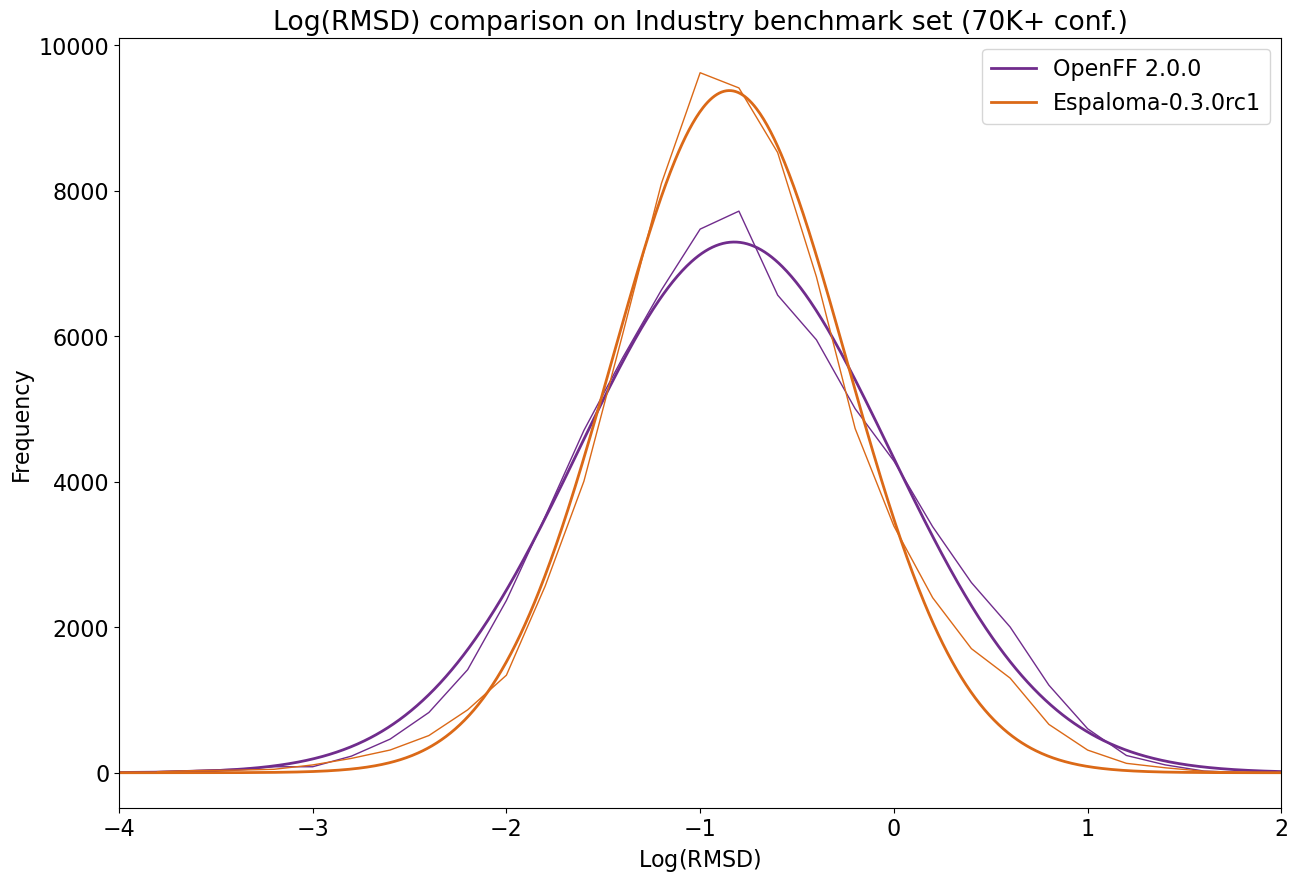

In [10]:


#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(15,10))#1,2, figsize=(10,5), gridspec_kw={'wspace':0.2})


labels = ff_list
for ii, forcefield in enumerate(labels):
    data = df.loc[df['Force Field'] == forcefield]["RMSD"]
#     data = data[data[data < 3]]
    data = np.log(data[data != 0])
    
    num_bins = 30
    hist,left = np.histogram(data,bins=num_bins, range=(-4,2))
    centers = left[:-1] + (left[1] - left[0])
    
    mean = np.mean(data)
    sigma = np.std(data)
    p0 = [1, mean, sigma] #starting values for the fit
    #fit the histogram
    p1,_ = curve_fit(gauss_function,centers,hist,p0,maxfev=100000)

#     ax.hist(data,bins=no_bins)
    x = np.linspace(left[0],left[-1],1000)
    y_fit = gauss_function(x, *p1)
    if forcefield == 'GAFF 2.11 + AM1BCC':
        ax.plot(x,y_fit,'-.', linewidth=2, label=labels[ii])
    else:
        ax.plot(x,y_fit,'-', linewidth=2, label=labels[ii], color=kelly[ii+1])
        ax.plot(centers, hist,'-', linewidth=1, color=kelly[ii+1])
    print(labels[ii], p1)

plt.xlim((-4, 2))    
plt.xlabel(r"$\mathregular{Log(RMSD)}$")
plt.ylabel("Frequency")
plt.legend()
plt.title('Log(RMSD) comparison on Industry benchmark set (70K+ conf.)')
plt.savefig('Log_transform_of_rmsd.png', dpi=300)
plt.show()



OpenFF 2.0.0 [ 4.04909325e+03 -3.23292915e+00  8.03259384e-01]
Espaloma-0.3.0rc1 [ 4.70330095e+03 -2.26617108e+00 -6.42758364e-01]


<Figure size 1500x1000 with 0 Axes>

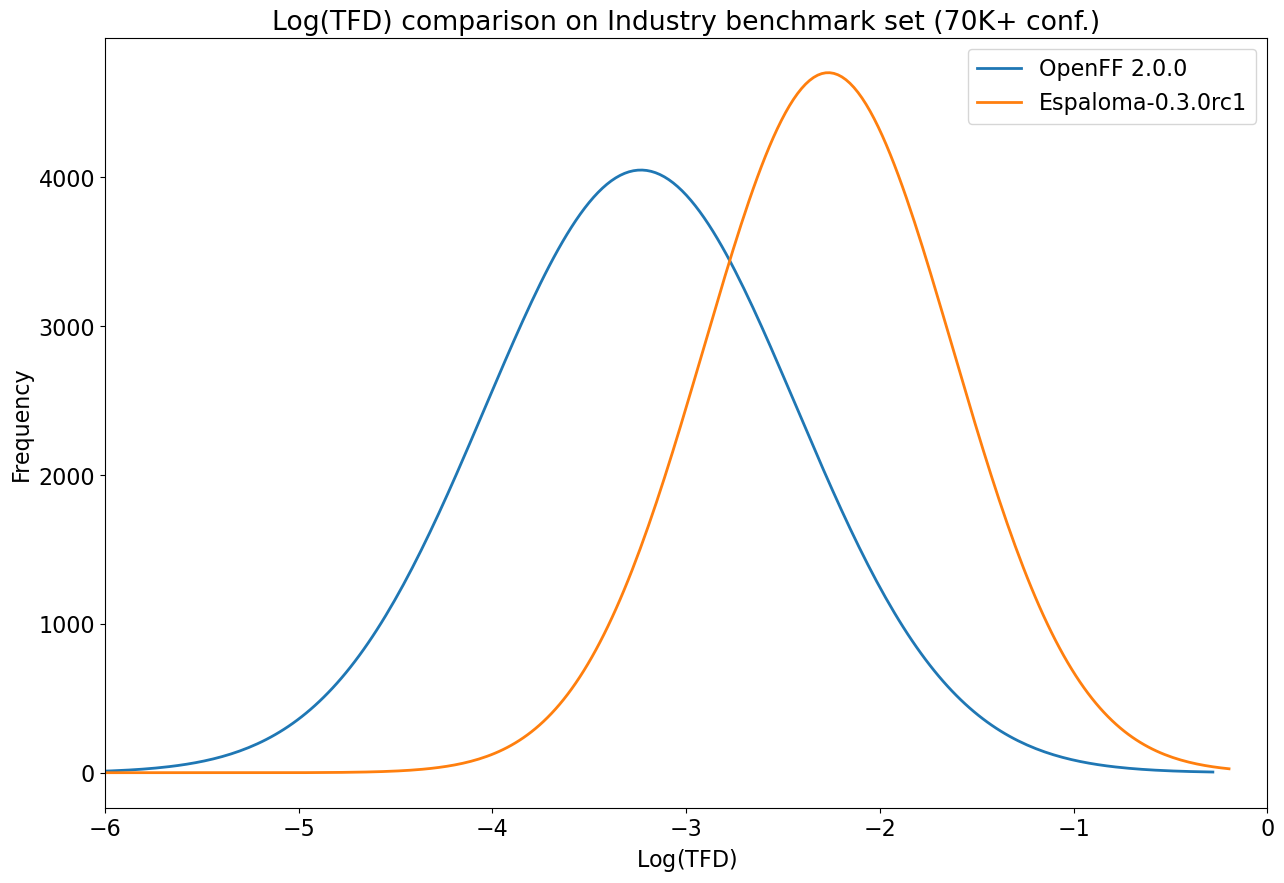

In [11]:
#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(15,10))#1,2, figsize=(10,5), gridspec_kw={'wspace':0.2})


labels = ff_list
for ii, forcefield in enumerate(labels):
    data = df.loc[df['Force Field'] == forcefield]["TFD"]
    data = data[~np.isnan(data)]
    data = np.log(data[data != 0])
    
    no_bins = 200
    hist,left = np.histogram(data,bins=no_bins)
    centers = left[:-1] + (left[1] - left[0])
    
    mean = np.mean(data)
    sigma = np.std(data)
    p0 = [1, mean, sigma] #starting values for the fit
    #fit the histogram
    p1,_ = curve_fit(gauss_function,centers,hist,p0,maxfev=100000)

#     ax.hist(data,bins=no_bins)
    x = np.linspace(left[0],left[-1],1000)
    y_fit = gauss_function(x, *p1)
    if forcefield == 'GAFF 2.11 + AM1BCC':
        ax.plot(x,y_fit,'-.', linewidth=2, label=labels[ii])
    else:
        ax.plot(x,y_fit,'-', linewidth=2, label=labels[ii])
    print(labels[ii], p1)

plt.xlim((-6, 0))    
plt.xlabel(r"$\mathregular{Log(TFD)}$")
plt.ylabel("Frequency")
plt.legend()
plt.title('Log(TFD) comparison on Industry benchmark set (70K+ conf.)')
plt.savefig('Log_transform_of_tfd.png', dpi=300)
plt.show()

OpenFF 2.0.0 [2.44677022e+03 5.91264567e-01 1.07608957e+00]
Espaloma-0.3.0rc1 [2.44416022e+03 4.21090431e-01 1.10262641e+00]


<Figure size 1500x1000 with 0 Axes>

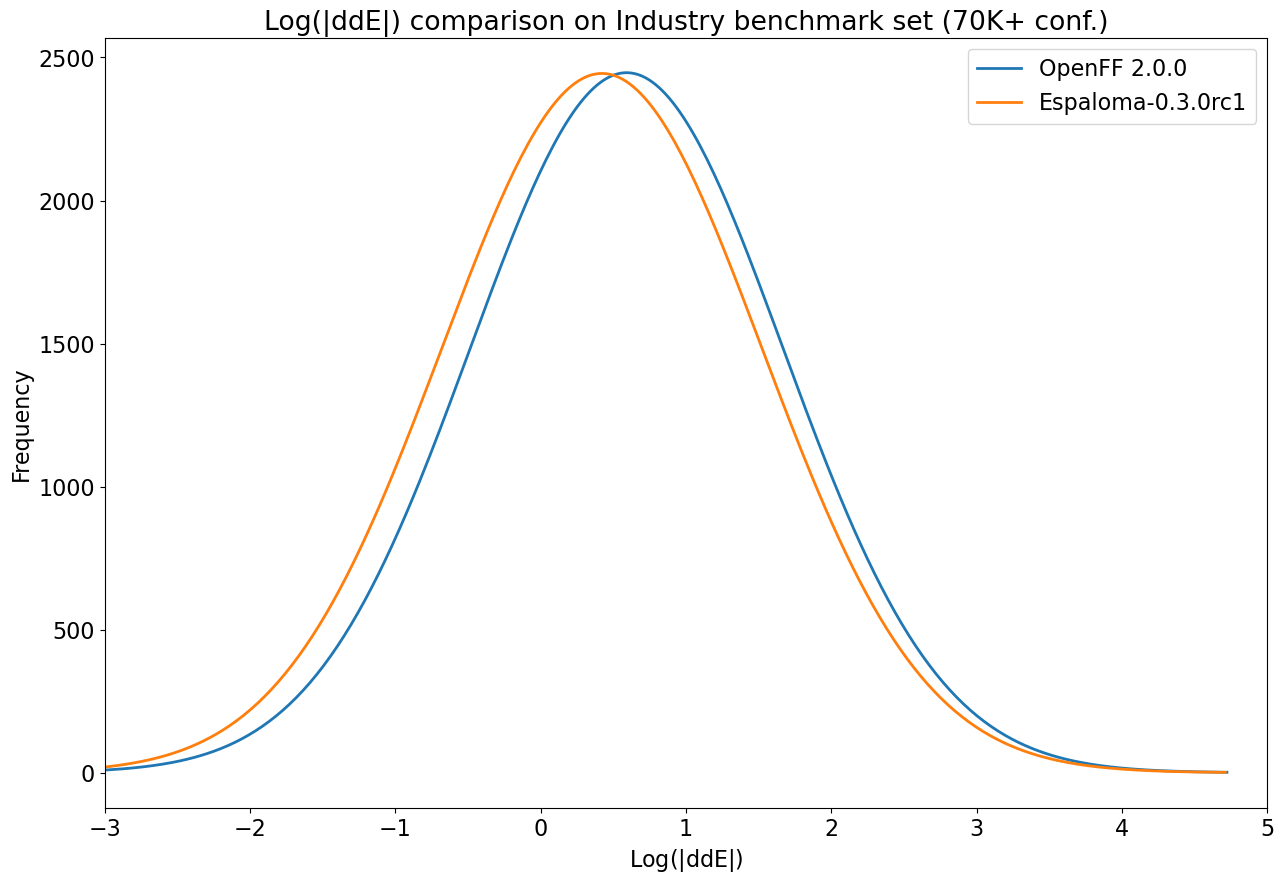

In [12]:
#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(15,10))#1,2, figsize=(10,5), gridspec_kw={'wspace':0.2})


labels = ff_list
for ii, forcefield in enumerate(labels):
    data = df.loc[df['Force Field'] == forcefield]["ddE"]
    data = data[~np.isnan(data)]
    data = np.log(np.abs(data[data != 0]))
    
    no_bins = 200
    hist,left = np.histogram(data,bins=no_bins)
    centers = left[:-1] + (left[1] - left[0])
    
    mean = np.mean(data)
    sigma = np.std(data)
    p0 = [1, mean, sigma] #starting values for the fit
    #fit the histogram
    p1,_ = curve_fit(gauss_function,centers,hist,p0,maxfev=100000)

#     ax.hist(data,bins=no_bins)
    x = np.linspace(left[0],left[-1],1000)
    y_fit = gauss_function(x, *p1)
    ax.plot(x,y_fit,'-', linewidth=2, label=labels[ii])
    print(labels[ii], p1)

plt.xlim((-3, 5))    
plt.xlabel(r"$\mathregular{Log(|ddE|)}$")
plt.ylabel("Frequency")
plt.legend()
plt.title('Log(|ddE|) comparison on Industry benchmark set (70K+ conf.)')
plt.savefig('Log_transform_of_absolute_ddE.png', dpi=300)
plt.show()

# KDE plots of the metrics RMSD/TFD/ddE

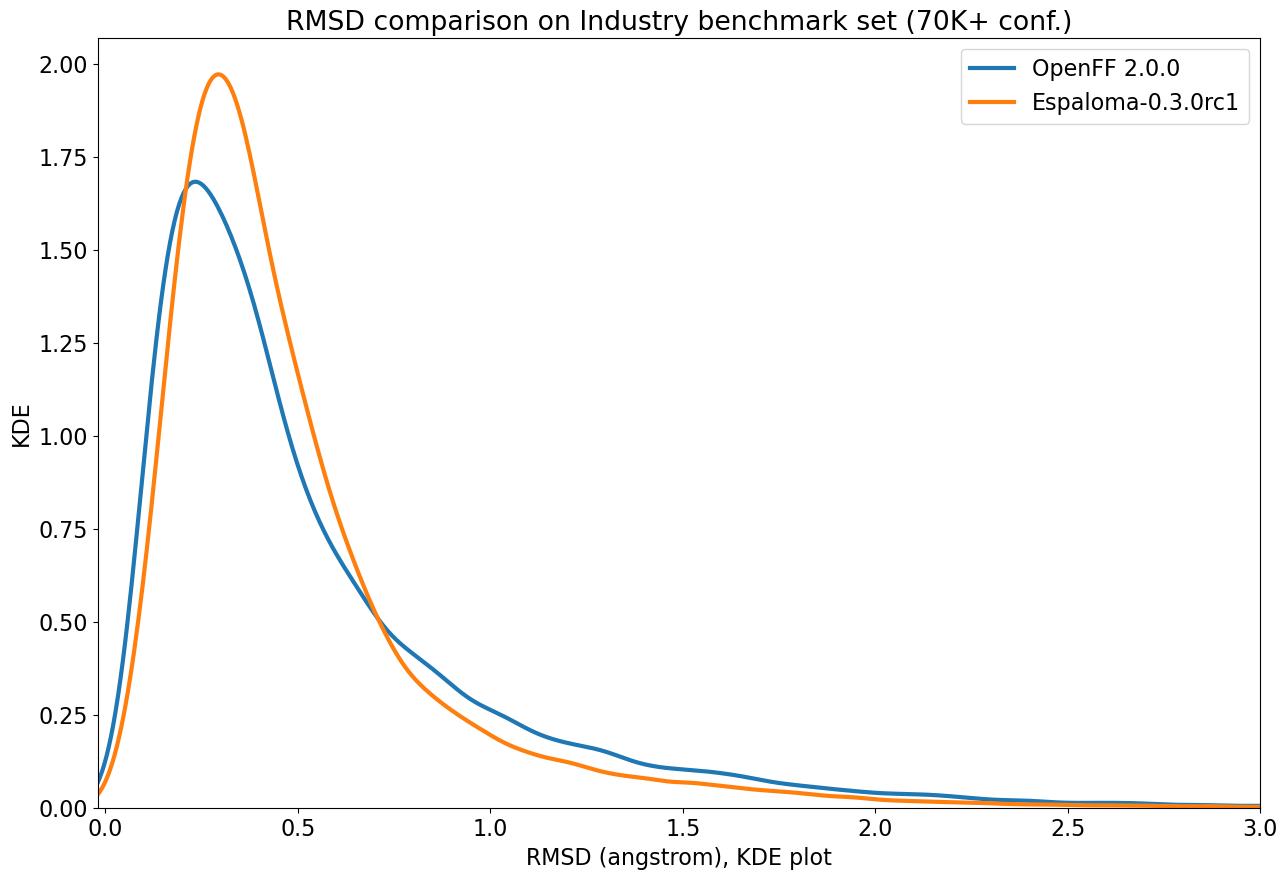

In [13]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["RMSD"], linestyle='-.', linewidth=3, label=forcefield, gridsize=1000, bw_adjust=1.0) ## using bin_centers rather than edges
    else:
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["RMSD"], linewidth=3, label=forcefield, gridsize=1000, bw_adjust=1.0)

plt.xlim(-0.02, 3)
plt.xlabel(f"RMSD (angstrom), KDE plot")
plt.ylabel("KDE")
plt.legend()
plt.title('RMSD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'KDE_plot_of_RMSD.png', dpi=300)
plt.show()

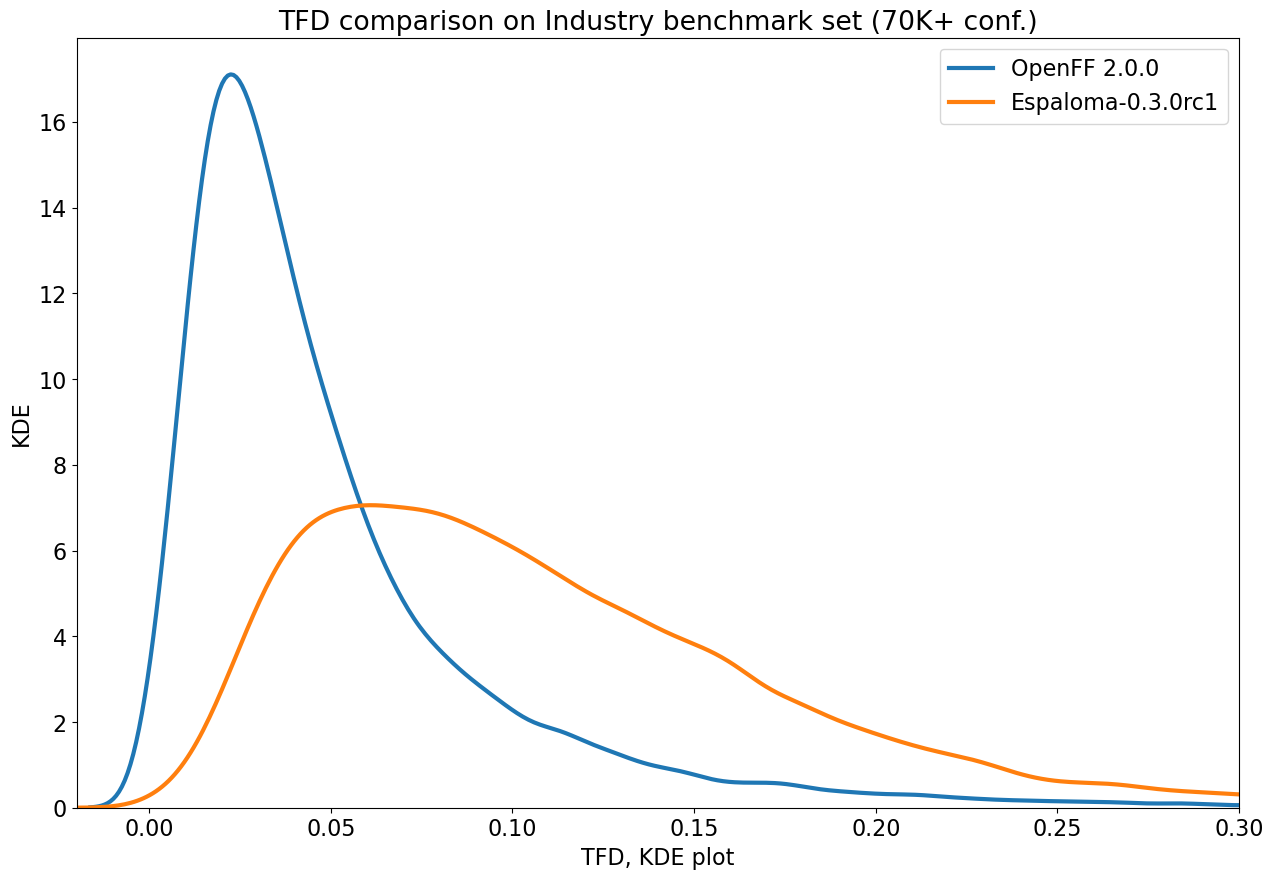

In [14]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["TFD"], linestyle='-.', linewidth=3, label=forcefield, gridsize=1000) ## using bin_centers rather than edges
    else:
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["TFD"], linewidth=3, label=forcefield, gridsize=1000)

plt.xlim(-0.02, 0.3)
plt.xlabel(f"TFD, KDE plot")
plt.ylabel("KDE")
plt.legend()
plt.title('TFD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'KDE_plot_of_TFD.png', dpi=300)
plt.show()

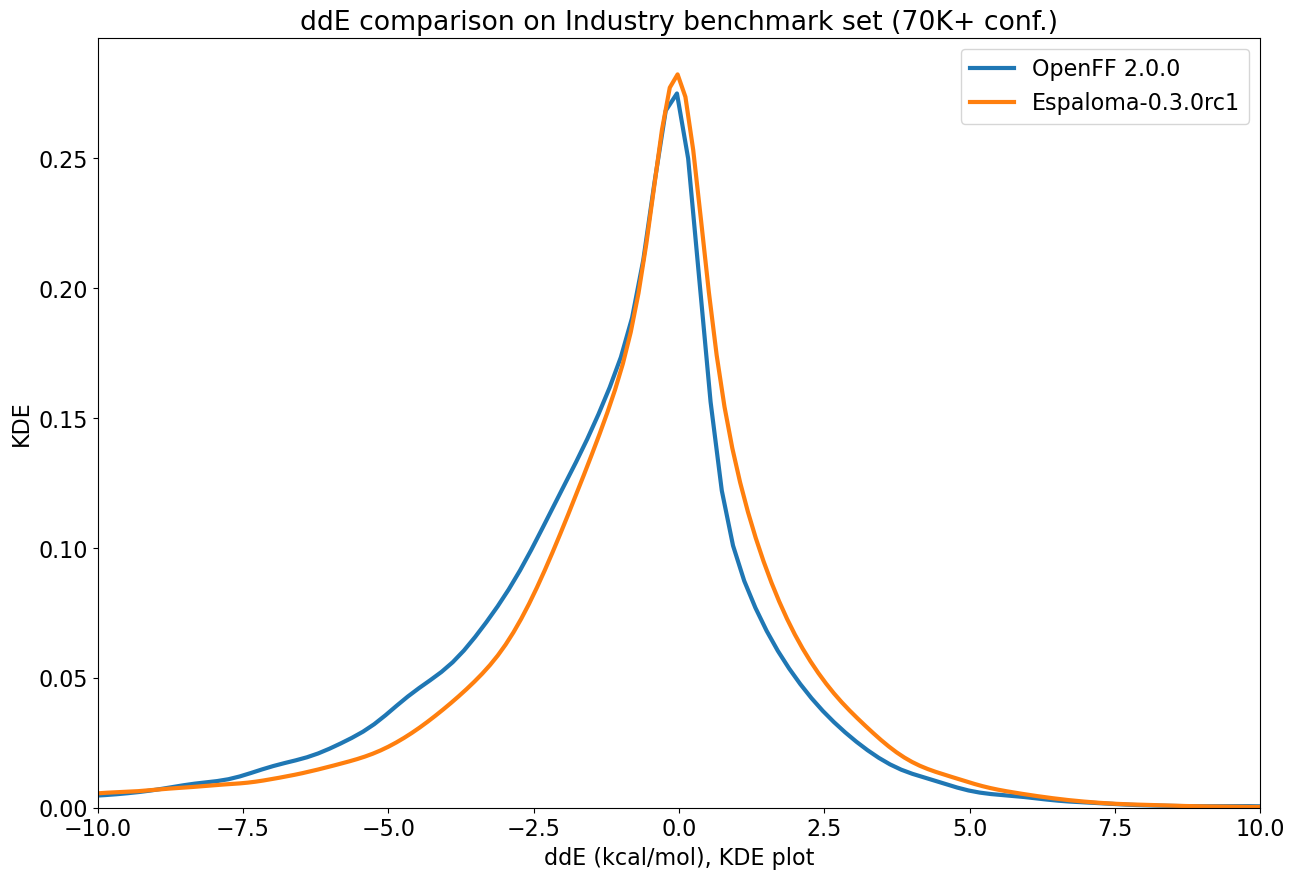

In [15]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["ddE"], linestyle='-.', linewidth=3, label=forcefield, gridsize=1000) ## using bin_centers rather than edges
    else:
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["ddE"], linewidth=3, label=forcefield, gridsize=1000)

plt.xlim(-10, 10)
plt.xlabel(f"ddE (kcal/mol), KDE plot")
plt.ylabel("KDE")
plt.legend()
plt.title('ddE comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'KDE_plot_of_ddE.png', dpi=300)
plt.show()

# Cumulative distributions of the metrics RMSD/TFD/ddE

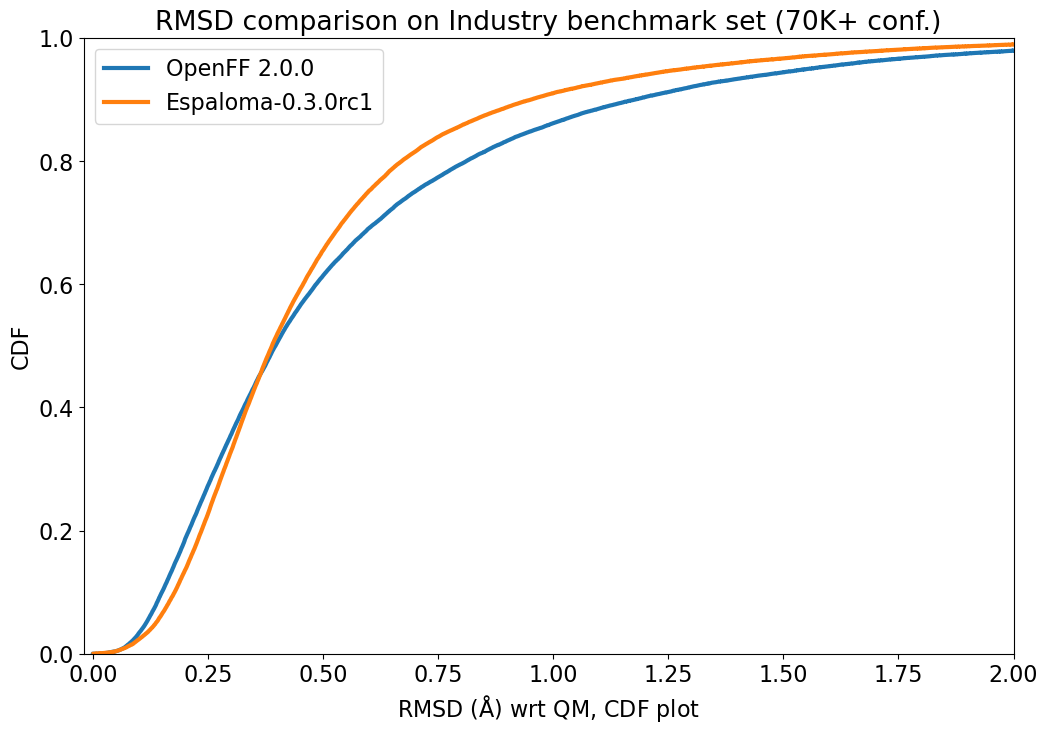

In [16]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.ecdfplot(df.loc[df['Force Field'] == forcefield]["RMSD"], linestyle='-.', linewidth=3, label=forcefield) 
    else:
        sns.ecdfplot(df.loc[df['Force Field'] == forcefield]["RMSD"], linewidth=3, label=forcefield)

plt.xlim(-0.02, 2)
plt.xlabel(r"RMSD ($\mathrm{\AA}$) wrt QM, CDF plot")
plt.ylabel("CDF")
plt.legend()
plt.title('RMSD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'CDF_plot_of_RMSD.png', dpi=300)
plt.show()

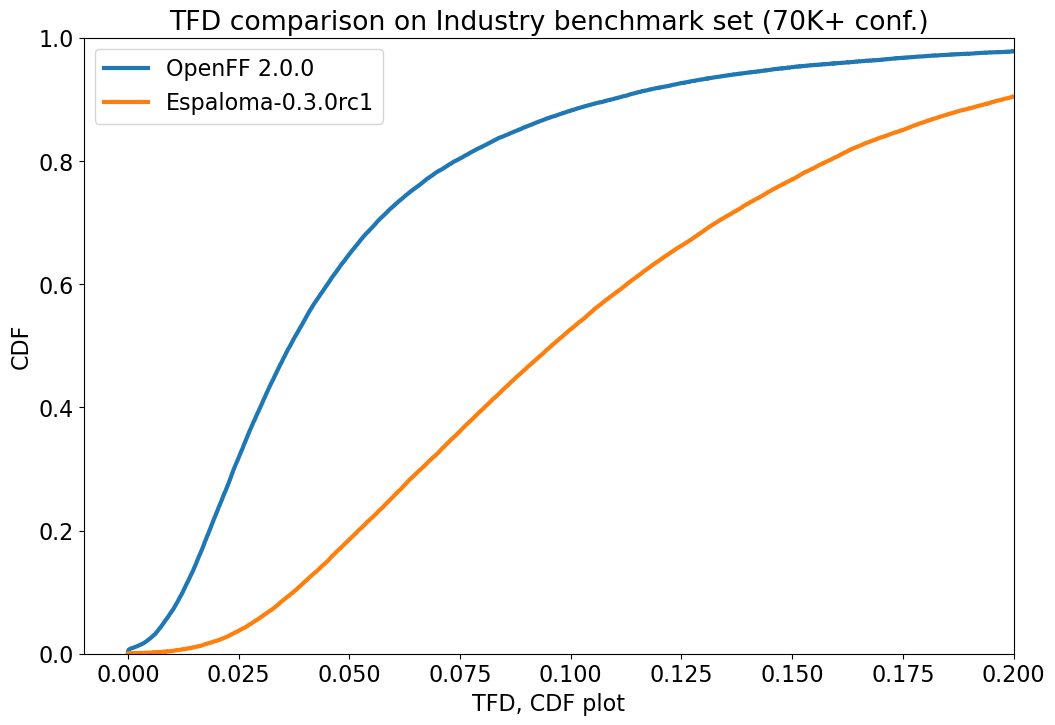

In [17]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.ecdfplot(df.loc[df['Force Field'] == forcefield]["TFD"], linestyle='-.', linewidth=3, label=forcefield)
    else:
        sns.ecdfplot(df.loc[df['Force Field'] == forcefield]["TFD"], linewidth=3, label=forcefield)

plt.xlim(-0.01, 0.2)
plt.xlabel(f"TFD, CDF plot")
plt.ylabel("CDF")
plt.legend()
plt.title('TFD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'CDF_plot_of_TFD.png', dpi=300)
plt.show()

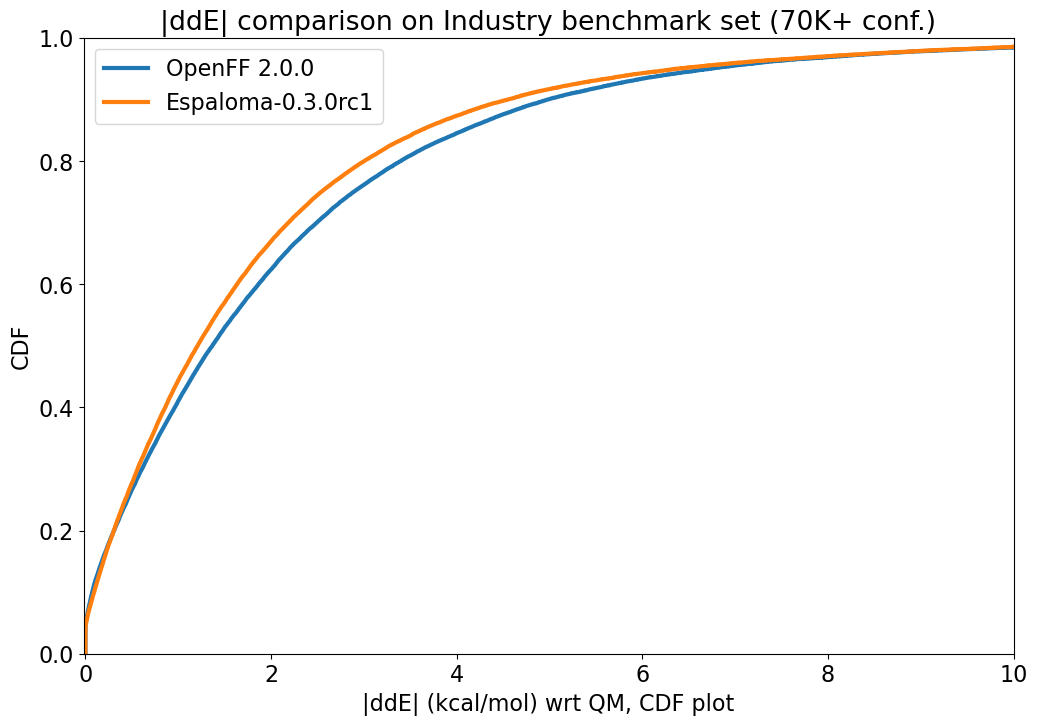

In [18]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.ecdfplot(abs(df.loc[df['Force Field'] == forcefield]["ddE"]), linestyle='-.', linewidth=3, label=forcefield)
    else:
        sns.ecdfplot(abs(df.loc[df['Force Field'] == forcefield]["ddE"]), linewidth=3, label=forcefield)

plt.xlim(-0.02, 10)
plt.xlabel(f"|ddE| (kcal/mol) wrt QM, CDF plot")
plt.ylabel("CDF")
plt.legend()
plt.title('|ddE| comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'CDF_plot_of_ddE.png', dpi=300)
plt.show()

# Log-normal distribution of data (instead of log transform and fitting to a gaussian)

2.0867586576543475
OpenFF 2.0.0, mean: -0.9308, sigma: 0.7571, scale: 0.39424737920282465
[0.24748703]
Std dev:  0.42417977712947785
Mean: 0.5250891056044487
1.6110838435322234
Espaloma-0.3.0rc1, mean: -0.9668, sigma: 0.6345, scale: 0.38031619061721506
[0.19695317]
Std dev:  0.3450120477033975
Mean: 0.4651180118452849


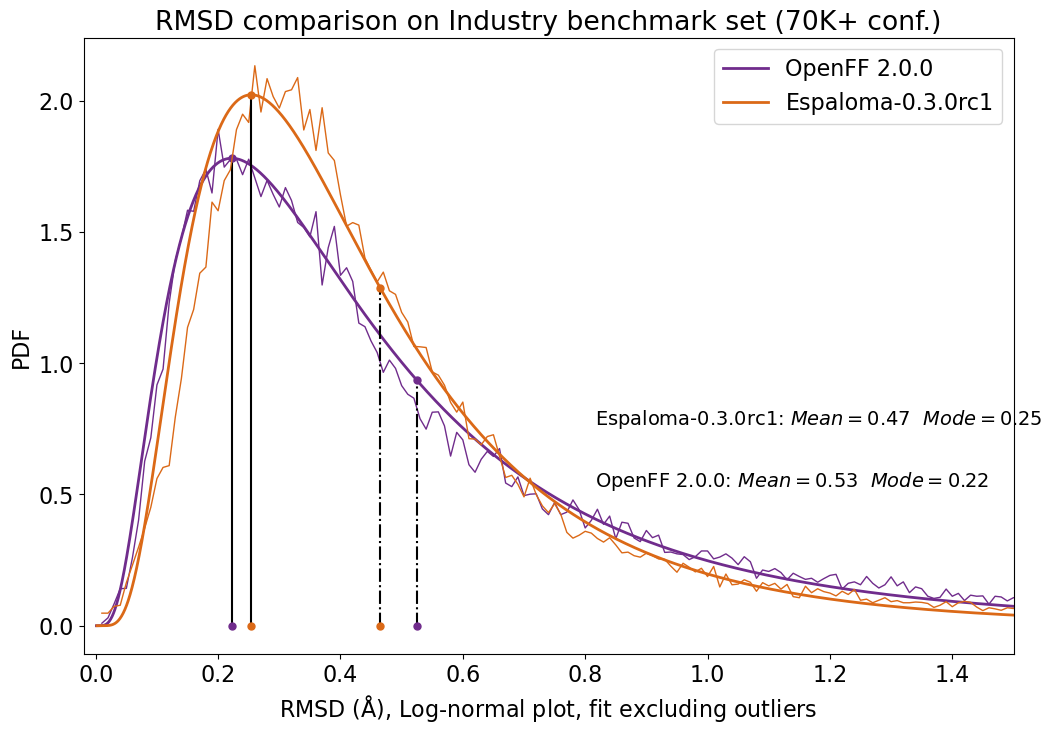

In [19]:
# %matplotlib
fix, ax = plt.subplots(figsize=(12,8))
plt.rcParams.update({'font.size': 16})

mean_plus_three_std = []
for i, forcefield in enumerate(ff_list):
    if forcefield == 'GAFF 2.11 + AM1BCC':
        data = df.loc[df['Force Field'] == forcefield]["RMSD"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
        plt.hist(data, bins=500, linestyle='-.', linewidth=2, label=forcefield, alpha=0.75, histtype='step')
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 10000)
        pdf = lognorm.pdf(x, s,  loc=loc, scale=scale)
        plt.plot(x, pdf, linestyle='-.', linewidth=5, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        
    else:
        data = df.loc[df['Force Field'] == forcefield]["RMSD"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        q3, q1 = np.percentile(data, [75 ,25])
        iqr = q3 - q1
        max_whisker = q3+3*iqr
        print(max_whisker)
        s, loc, scale = lognorm.fit(data[data < max_whisker], floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
        num_bins = 300
        hist,left = np.histogram(data, bins=num_bins, range=(0,3), density=True)
        centers = left[:-1] + (left[1] - left[0])
#         plt.hist(data, bins=300, linestyle='-', linewidth=1, alpha=1.0, histtype='step', color=kelly[i+1], density=True, range=(0, 3))
        plt.plot(centers, hist, linestyle='-', linewidth=1, alpha=1.0, color=kelly[i+1])
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 10000)
        pdf = lognorm.pdf(x, s, loc=loc, scale=scale)
        plt.plot(x, pdf, linewidth=2, label=forcefield, color=kelly[i+1])
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}, scale: {scale}")
        print(lognorm.pdf([1], s, loc=loc, scale=scale))
        print("Std dev: ", np.sqrt(np.exp(estimated_sigma**2 - 1)*np.exp(2*estimated_mu + estimated_sigma**2)))
        print("Mean:", np.exp(estimated_mu+0.5*estimated_sigma**2))
        mean_plus_three_std.append(np.exp(estimated_mu+0.5*estimated_sigma**2) + 3*np.sqrt(np.exp(estimated_sigma**2 - 1)*np.exp(2*estimated_mu + estimated_sigma**2)))
        x_mode = np.exp(estimated_mu - estimated_sigma*estimated_sigma)
        x_mean = np.exp(estimated_mu+0.5*estimated_sigma**2)
        plt.plot([x_mode, x_mode], [0, lognorm.pdf(x_mode, s, loc=loc, scale=scale)], 'k-')
        plt.plot([x_mode, x_mode], [0, lognorm.pdf(x_mode, s, loc=loc, scale=scale)], 'o', color=kelly[i+1], ms=5)
        plt.plot([x_mean, x_mean], [0, lognorm.pdf(x_mean, s, loc=loc, scale=scale)], 'k-.')
        plt.plot([x_mean, x_mean], [0, lognorm.pdf(x_mean, s, loc=loc, scale=scale)], 'o', color=kelly[i+1], ms=5)
        textstr = ' '.join((forcefield+r': $Mean=%.2f$' % (x_mean), r' $Mode=%.2f$' % (x_mode),'\n'))
        ax.text(0.55, 0.3+i/10, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top')

plt.xlim(-0.02, min(mean_plus_three_std))
plt.xlabel(r"RMSD ($\mathrm{\AA}$), Log-normal plot, fit excluding outliers")
plt.ylabel("PDF")
plt.legend()
plt.title('RMSD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'lognormal_plot_of_RMSD.png', dpi=300)
plt.show()

0.19217747756242337
OpenFF 2.0.0, mean: -3.3415, sigma: 0.7881, scale: 0.03538217507188726
[6.32092251e-05]
Std dev:  0.039938912298071616
Mean: 0.04826852197489283
0.40133824923507805
Espaloma-0.3.0rc1, mean: -2.4126, sigma: 0.6575, scale: 0.08958532436530466
[0.00072315]
Std dev:  0.08371943331380051
Mean: 0.11120010458892224


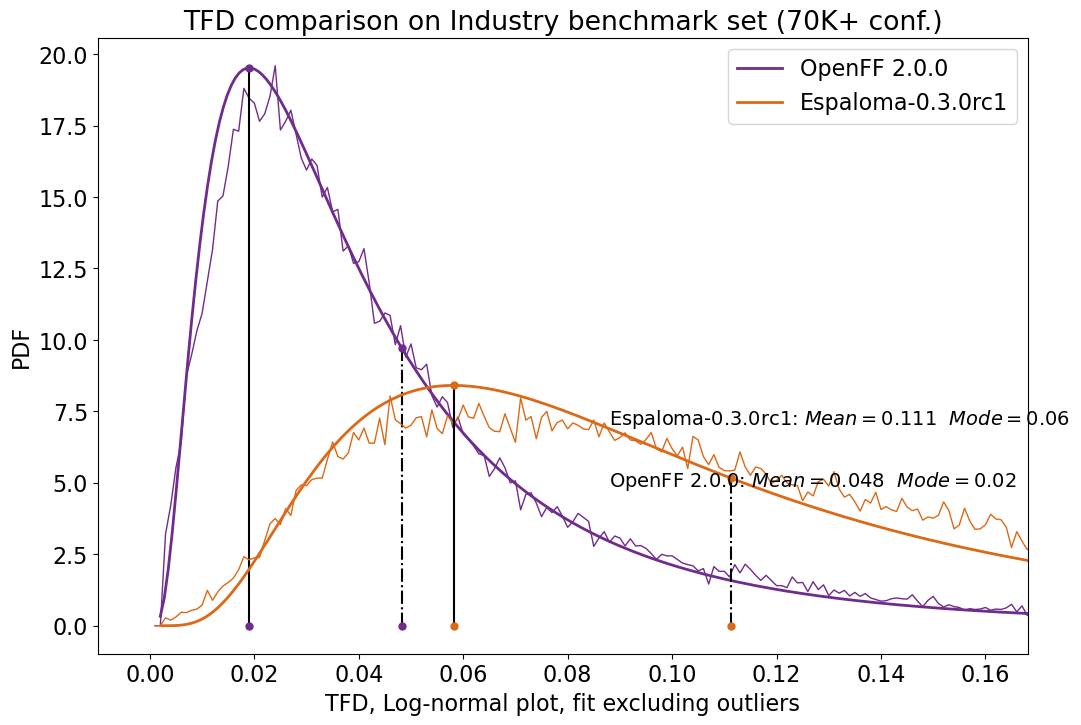

In [20]:
# %matplotlib
fix, ax = plt.subplots(figsize=(12,8))
plt.rcParams.update({'font.size': 16})

mean_plus_three_std = []
for i, forcefield in enumerate(ff_list):
    if forcefield == 'GAFF 2.11 + AM1BCC':
        data = df.loc[df['Force Field'] == forcefield]["TFD"]
        data = data[np.abs(data) > 0.001]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
        plt.hist(data, bins=500, linestyle='-.', linewidth=2, label=forcefield, alpha=0.75, histtype='step')
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 10000)
        pdf = lognorm.pdf(x, s,  loc=loc, scale=scale)
        plt.plot(x, pdf, linestyle='-.', linewidth=5, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        
    else:
        data = df.loc[df['Force Field'] == forcefield]["TFD"]
        data = data[np.abs(data) > 0.002]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        q3, q1 = np.percentile(data, [75 ,25])
        iqr = q3 - q1
        max_whisker = q3+3*iqr
        print(max_whisker)
        s, loc, scale = lognorm.fit(data[data < max_whisker], floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
        num_bins = 300
        hist,left = np.histogram(data, bins=num_bins, range=(0,0.3), density=True)
        centers = left[:-1] + (left[1] - left[0])
#         plt.hist(data, bins=300, linestyle='-', linewidth=1, alpha=1.0, histtype='step', color=kelly[i+1], density=True, range=(0, 3))
        plt.plot(centers, hist, linestyle='-', linewidth=1, alpha=1.0, color=kelly[i+1])
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 1000)
        pdf = lognorm.pdf(x, s, loc=loc, scale=scale)
        plt.plot(x, pdf, linewidth=2, label=forcefield, color=kelly[i+1])
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}, scale: {scale}")
        print(lognorm.pdf([1], s, loc=loc, scale=scale))
        print("Std dev: ", np.sqrt(np.exp(estimated_sigma**2 - 1)*np.exp(2*estimated_mu + estimated_sigma**2)))
        print("Mean:", np.exp(estimated_mu+0.5*estimated_sigma**2))
        mean_plus_three_std.append(np.exp(estimated_mu+0.5*estimated_sigma**2) + 3*np.sqrt(np.exp(estimated_sigma**2 - 1)*np.exp(2*estimated_mu + estimated_sigma**2)))
        x_mode = np.exp(estimated_mu - estimated_sigma*estimated_sigma)
        x_mean = np.exp(estimated_mu+0.5*estimated_sigma**2)
        plt.plot([x_mode, x_mode], [0, lognorm.pdf(x_mode, s, loc=loc, scale=scale)], 'k-')
        plt.plot([x_mode, x_mode], [0, lognorm.pdf(x_mode, s, loc=loc, scale=scale)], 'o', color=kelly[i+1], ms=5)
        plt.plot([x_mean, x_mean], [0, lognorm.pdf(x_mean, s, loc=loc, scale=scale)], 'k-.')
        plt.plot([x_mean, x_mean], [0, lognorm.pdf(x_mean, s, loc=loc, scale=scale)], 'o', color=kelly[i+1], ms=5)
        textstr = ' '.join((forcefield+r': $Mean=%.3f$' % (x_mean), r' $Mode=%.2f$' % (x_mode),'\n'))
        ax.text(0.55, 0.3+i/10, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top')

plt.xlim(-0.01, min(mean_plus_three_std))
plt.xlabel(r"TFD, Log-normal plot, fit excluding outliers")
plt.ylabel("PDF")
plt.legend()
plt.title('TFD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'lognormal_plot_of_TFD.png', dpi=300)
plt.show()

OpenFF 2.0.0, mean: -3.3576, sigma: 1.0821
Espaloma-0.3.0rc1, mean: -2.4156, sigma: 0.7147


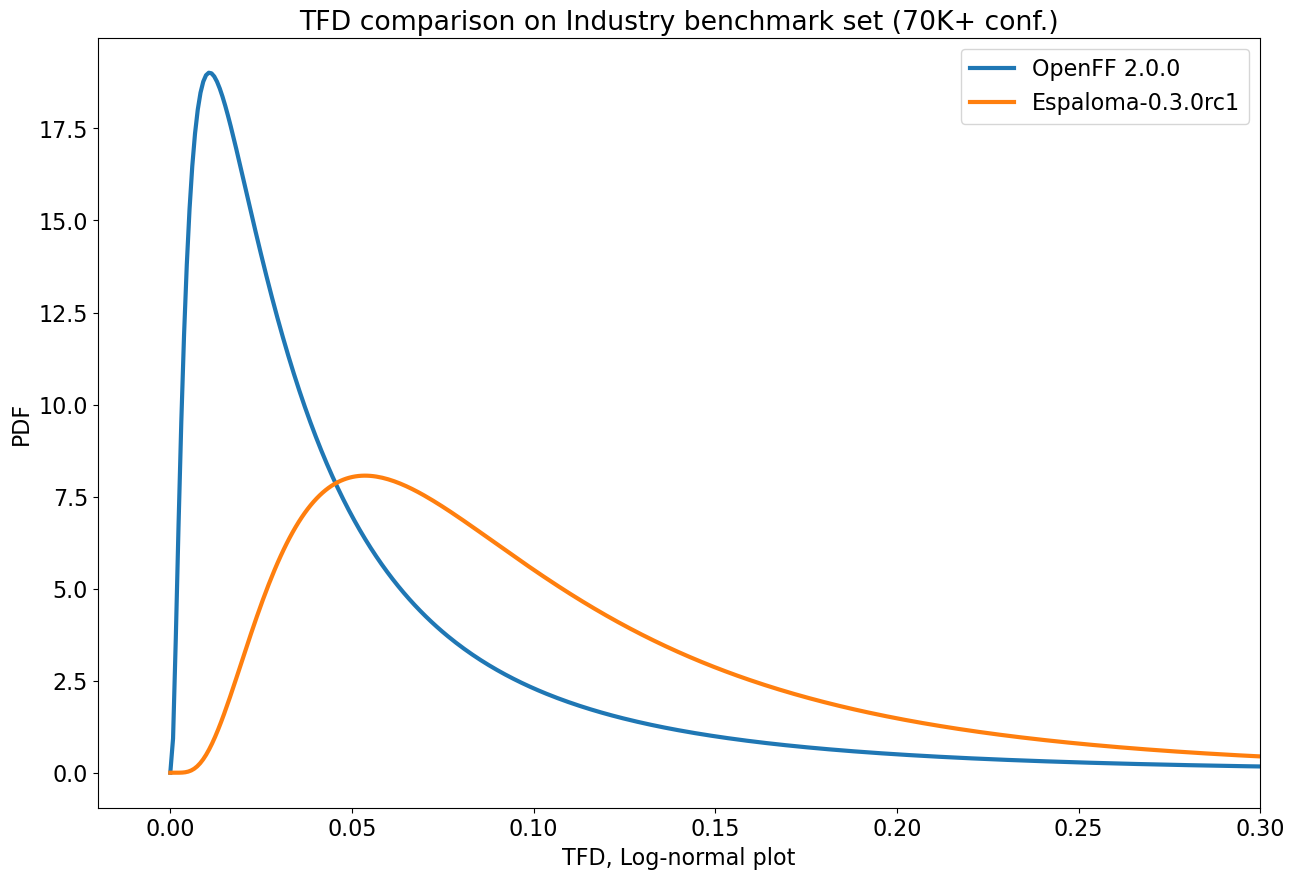

In [21]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        data = df.loc[df['Force Field'] == forcefield]["TDF"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
#         plt.hist(data, bins=500, linestyle='-.', linewidth=3, label=forcefield, alpha=0.75)
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 1000)
        pdf = lognorm.pdf(x, s,  loc=loc, scale=scale)
        plt.plot(x, pdf, linestyle='-.', linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        
    else:
        data = df.loc[df['Force Field'] == forcefield]["TFD"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
#         plt.hist(data, bins=500, alpha=0.75)
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 1000)
        pdf = lognorm.pdf(x, s, loc=loc, scale=scale)
        plt.plot(x, pdf, linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        

plt.xlim(-0.02, 0.3)
plt.xlabel(f"TFD, Log-normal plot")
plt.ylabel("PDF")
plt.legend()
plt.title('TFD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'lognormal_plot_of_TFD.png', dpi=300)
plt.show()

OpenFF 2.0.0, mean: -0.3281, sigma: 2.4509
Espaloma-0.3.0rc1, mean: -0.3736, sigma: 2.3616


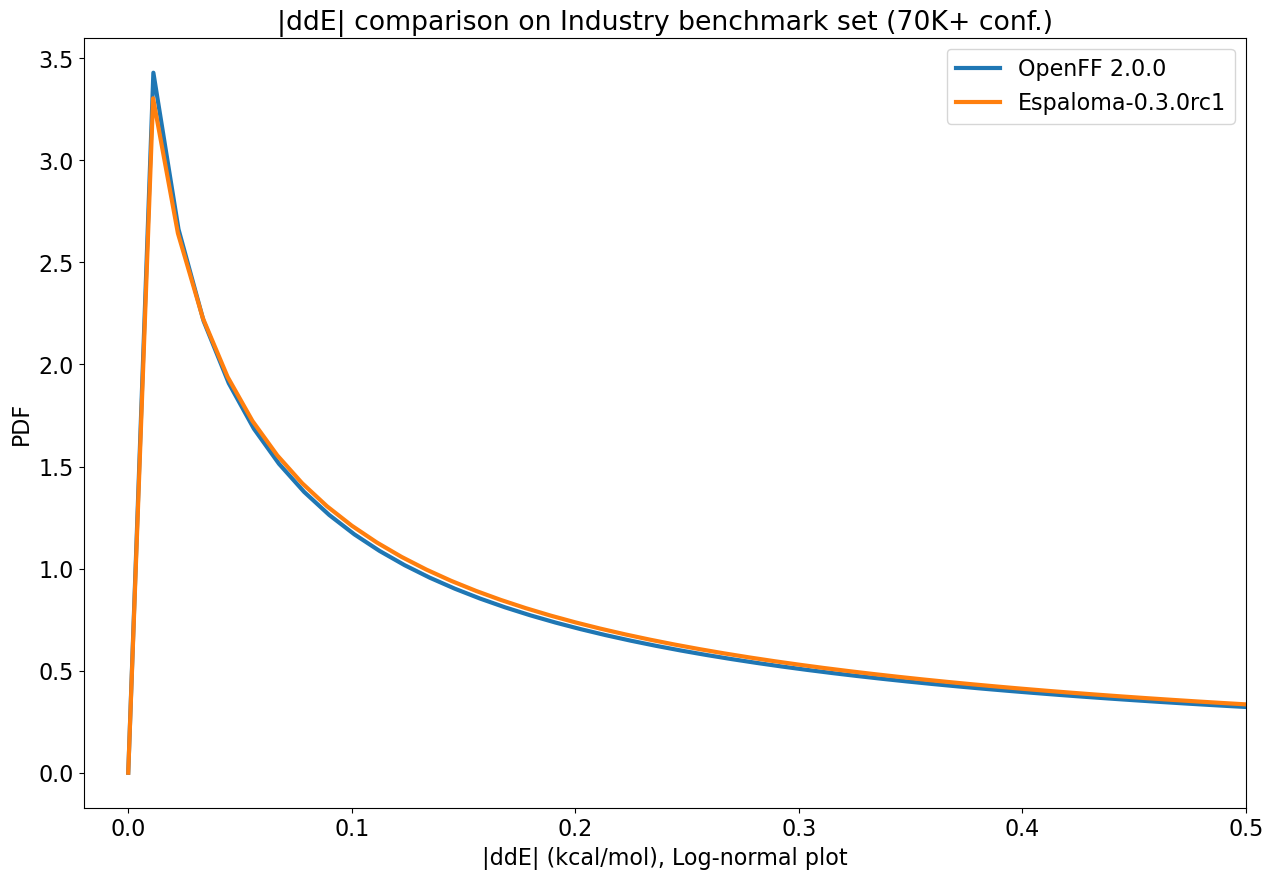

In [22]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        data = df.loc[df['Force Field'] == forcefield]["ddE"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        data = np.abs(data)
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 10000)
        pdf = lognorm.pdf(x, s,  loc=loc, scale=scale)
        plt.plot(x, pdf, linestyle='-.', linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        
    else:
        data = df.loc[df['Force Field'] == forcefield]["ddE"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        data = np.abs(data)
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 10000)
        pdf = lognorm.pdf(x, s, loc=loc, scale=scale)
        plt.plot(x, pdf, linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")


plt.xlim(-0.02, 0.5)
plt.xlabel(f"|ddE| (kcal/mol), Log-normal plot")
plt.ylabel("PDF")
plt.legend()
plt.title('|ddE| comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'lognormal_plot_of_ddE.png', dpi=300)
plt.show()